In [1]:
import iris
from iris.experimental.equalise_cubes import equalise_attributes
import iris.quickplot as qp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

import os
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# User Settings

In [2]:
## Define parameters to filter files
set_experiment = 'rcp85'

set_season = 'annual'
# near, mid or far (future)
set_time = 'far' 

# select bounding box
set_lat = (-6,-5)
set_lon = (2, 3)

# path to files with climate change signal
set_path = 'data/climaproof' 

# Definitions

In [3]:
choose_time = {'near': "2021-2050",
               'mid': "2036-2065",
               'far': "2070-2099"}

Define a function to add a scalar dimension realization when we load the datasets.

In [4]:
realization = 0

In [5]:
def lagged_ensemble_callback(cube, field, filename):
    # Add our own realization coordinate if it doesn't already exist.
    if not cube.coords('realization'):
        global realization 
        realization += 1
        ensemble_coord = iris.coords.AuxCoord(realization, standard_name='realization')
        cube.add_aux_coord(ensemble_coord)

# Load data as iris cubes (CubeList)

In [6]:
cl_pr = iris.load_raw(
    os.path.join(set_path,"ccs_pr_{}_*_{}_*_{}.nc".format(set_season, set_experiment, choose_time[set_time])), 
    callback=lagged_ensemble_callback)

In [7]:
cl_tas =  iris.load_raw(
    os.path.join(set_path,"ccs_tasmax_{}_*_{}_*_{}.nc".format(set_season, set_experiment, choose_time[set_time])), 
    callback=lagged_ensemble_callback)

Contourplot of the first timeslice in first cube of the loaded CubeList

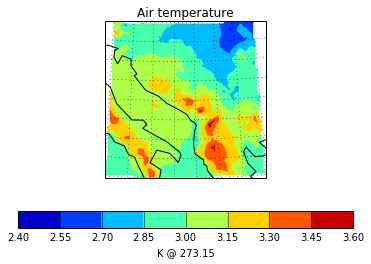

In [8]:
qp.contourf(cl_tas[0][0,:,:])
ax = plt.gca()
ax.gridlines()
plt.gca().coastlines()
qp.show()

## Spatial averaging

In [9]:
for i in range(len(cl_pr)):
    cl_pr[i] = cl_pr[i].intersection(grid_latitude=set_lat, grid_longitude=set_lon
                                    ).collapsed(['grid_latitude','grid_longitude'],iris.analysis.MEAN)
    cl_tas[i] = cl_tas[i].intersection(grid_latitude=set_lat, grid_longitude=set_lon
                                      ).collapsed(['grid_latitude','grid_longitude'],iris.analysis.MEAN)

Extract model names and compare the order of the names for the different parameters

In [10]:
ls_models_tas = [c_tas.attributes['model'] for c_tas in cl_tas]
ls_models_pr = [c_pr.attributes['model'] for c_pr in cl_pr]

In [11]:
ls_models_tas == ls_models_pr

True

Equalise attributes of cubes and merge them to get new dimension realization

In [12]:
equalise_attributes(cl_pr)
equalise_attributes(cl_tas)

In [13]:
cl_pr_merge = cl_pr.merge_cube()
cl_tas_merge = cl_tas.merge_cube()

In [14]:
cl_tas_merge

<iris 'Cube' of air_temperature / (degree_Celsius) (realization: 16; time: 1)>

# Blend with pandas

Create pandas series from cube data

In [15]:
ccs_series_pr = pd.Series(cl_pr_merge.data[:,0], index = ls_models_pr, name="ccs_pr")

In [16]:
ccs_series_tas = pd.Series(cl_tas_merge.data[:,0], index = ls_models_tas, name="ccs_tas")

Calculate percentiles of score for the climate change signals of the different models

In [17]:
ccs_perc_pr = pd.Series(ccs_series_pr.rank(pct=True)*100, name="percentiles")
ccs_perc_tas = pd.Series(ccs_series_tas.rank(pct=True)*100, name="percentiles")

Concat series to create pandas DataFrame

In [18]:
pd_df_pr = pd.concat([ccs_series_pr, ccs_perc_pr], axis=1)
pd_df_tas = pd.concat([ccs_series_tas, ccs_perc_tas], axis=1)

Show table and sort by column percentiles

In [19]:
pd_df_pr.sort_values("percentiles")

,ccs_pr,percentiles
MPI-M-MPI-ESM-LR_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1,-3.771723,6.25
MOHC-HadGEM2-ES_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1,-1.955711,12.50
MPI-M-MPI-ESM-LR_rcp85_r1i1p1_MPI-CSC-REMO2009_v1,1.971074,18.75
IPSL-IPSL-CM5A-MR_rcp85_r1i1p1_SMHI-RCA4_v1,3.439654,25.00
ICHEC-EC-EARTH_rcp85_r12i1p1_KNMI-RACMO22E_v1,3.450866,31.25
CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_SMHI-RCA4_v1,5.132025,37.50
CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1,5.676598,43.75
NCC-NorESM1-M_rcp85_r1i1p1_DMI-HIRHAM5_v2,5.784793,50.00
ICHEC-EC-EARTH_rcp85_r1i1p1_KNMI-RACMO22E_v1,6.496072,56.25
MPI-M-MPI-ESM-LR_rcp85_r2i1p1_MPI-CSC-REMO2009_v1,8.390728,62.50


In [20]:
pd_df_tas.sort_values("percentiles")

,ccs_tas,percentiles
NCC-NorESM1-M_rcp85_r1i1p1_DMI-HIRHAM5_v2,2.752495,6.25
CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1,2.755240,12.50
ICHEC-EC-EARTH_rcp85_r12i1p1_CLMcom-CCLM4-8-17_v1,2.843318,18.75
ICHEC-EC-EARTH_rcp85_r3i1p1_DMI-HIRHAM5_v1,3.171101,25.00
MPI-M-MPI-ESM-LR_rcp85_r2i1p1_MPI-CSC-REMO2009_v1,3.326051,31.25
CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_SMHI-RCA4_v1,3.352316,37.50
MPI-M-MPI-ESM-LR_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1,3.584966,43.75
IPSL-IPSL-CM5A-MR_rcp85_r1i1p1_IPSL-INERIS-WRF331F_v1,3.672141,50.00
ICHEC-EC-EARTH_rcp85_r1i1p1_KNMI-RACMO22E_v1,3.699764,56.25
MPI-M-MPI-ESM-LR_rcp85_r1i1p1_MPI-CSC-REMO2009_v1,3.804420,62.50


## Create scatter plot

In [21]:
pd_df_scatter = pd.concat([ccs_series_tas, ccs_series_pr], axis=1)

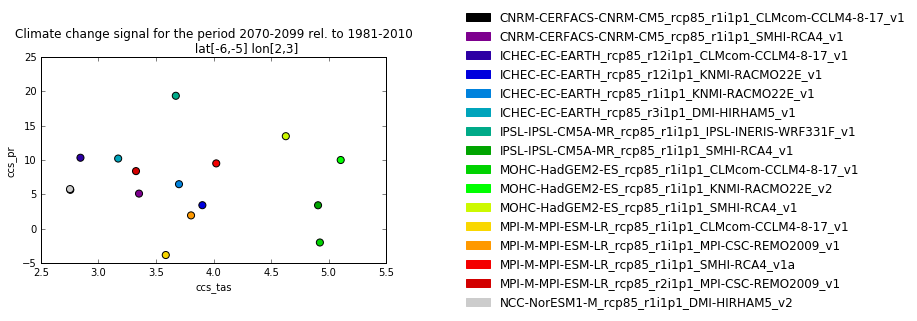

In [22]:
colors = cm.nipy_spectral(np.linspace(0, 1, len(ls_models_pr)))
pd_df_scatter.plot.scatter(x='ccs_tas', y='ccs_pr', color=colors, s=50,
        title="""Climate change signal for the period {} rel. to 1981-2010
                 lat[{},{}] lon[{},{}]""".format(choose_time[set_time],set_lat[0],set_lat[1], set_lon[0], set_lon[1]))

patches = [
    mpatches.Patch(color=color, label=label)
    for label, color in zip(pd_df_scatter.index, colors)]
plt.legend(patches, pd_df_scatter.index, frameon=False,loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.tight_layout()